In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import preprocessing
color = sns.color_palette()
%matplotlib inline


In [2]:
df_train = pd.read_json('price_vs_median30.json')
df_test = pd.read_json('test.json')

In [3]:
from pandas import to_datetime
import numpy as np
import re


def basic_numeric_features(df):
    df["num_photos"] = df["photos"].apply(len)
    df["num_features"] = df["features"].apply(len)
    df["num_description_words"] = df[
        "description"].apply(lambda x: len(x.split(" ")))
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df["created_hour"] = df["created"].dt.hour
    return df


def num_keyword(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('elevator|cats|dogs|doorman|dishwasher|no fee|laundry|fitness', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i <= 5:
            nfeat_score.append(0)
        elif i == 6:
            nfeat_score.append(1)
        elif i == 7:
            nfeat_score.append(2)
        elif i == 8:
            nfeat_score.append(3)
        elif i == 9:
            nfeat_score.append(4)
        elif i == 10:
            nfeat_score.append(5)
        else:
            nfeat_score.append(6)

    df['n_num_keyfeat_score'] = nfeat_score
    return df


def no_photo(df):
    df['n_no_photo'] = [1 if i == 0 else 0 for i in map(len, df['photos'])]
    return df


def count_caps(df):
    def get_caps(message):
        caps = sum(1 for c in message if c.isupper())
        total_characters = sum(1 for c in message if c.isalpha())
        if total_characters > 0:
            caps = caps / (total_characters * 1.0)
        return caps
    df['amount_of_caps'] = df['description'].apply(get_caps)
    return df


def has_phone(df):
    # http://stackoverflow.com/questions/16699007/regular-expression-to-match-standard-10-digit-phone-number
    phone_regex = "(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})"
    has_phone = df['description'].str.extract(phone_regex)
    df['has_phone'] = [type(item) == unicode for item in has_phone]
    return df


def n_log_price(df):
    # n_price_sqrt improves original 'price' variable smoothing extreme
    # right skew and fat tails.
    # Use either 'price' or this new var to avoid multicolinearity.
    df['n_log_price'] = np.log(df['price'])
    return df


def n_expensive(df):
    # 'Low' interest make 70% population. Statistical analysis shows price
    # among 'Low' interest exhibits the highest kurtosis and skew.
    # n_expensive is 1 when the price is above 75% percentile aggregate
    # prices and 0 otherwise.
    # you can use it along with either price or n_price_sqrt.
    threshold_75p = df[['price']].describe().loc['75%', 'price']
    df['n_expensive'] = [
        1 if i > threshold_75p else 0 for i in list(df['price'])]
    return df


def dist_from_midtown(df):
    from geopy.distance import vincenty
    # pip install geopy
    # https://github.com/geopy/geopy
    # calculates vincenty dist
    # https://en.wikipedia.org/wiki/Vincenty's_formulae
    lat = df['latitude'].tolist()
    long_ = df['longitude'].tolist()
    midtown_lat = 40.7586
    midtown_long = -73.9838
    distance = []
    for i in range(len(lat)):
        distance.append(
            vincenty((lat[i], long_[i]), (midtown_lat, midtown_long)).meters)
    df['distance_from_midtown'] = distance
    return df


def price_vs_mean_30(df):
    # userfriendly for def_nearest_neighbour created earlier.
    # Output: df with price_vs_median for each row
    # The code below solves NA issues and round some results to save execution errors
    temp = pd.read_json("price_vs_median30.json")['price_vs_median_30']
    mean = np.mean(temp) 
    import math
    df['price_vs_median_30'] = [mean if math.isnan(i)== True  else round(i,2) for i in temp]

    return df



In [4]:
df_train.created = pd.to_datetime(df_train.created)

In [5]:
df_train['date_created'] = df_train.created.dt.date
df_train['weekday_created'] = df_train.created.dt.dayofweek
df_train['hour_created'] = df_train.created.dt.hour
df_train["created_day"] = df_train["created"].dt.day

df_train["num_photos"] = df_train["photos"].apply(len)
df_train["num_features"] = df_train["features"].apply(len)
df_train["num_description_words"] = df_train["description"].apply(lambda x: len(x.split(" ")))

df_train['interest_level'] = pd.Categorical(df_train['interest_level'], categories= ['low', 'medium', 'high'], ordered=True)

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_train['manager_id'].values))
df_train['manager_id'] = lbl.transform(list(df_train['manager_id'].values))
#list of id's to encode
manager_ids = list(df_train['manager_id'].values)
#new var to create
new_var = 'manager_id'#'manager_id_encoded'
#response var
resp_var = 'interest_level'


temp = pd.concat([df_train[new_var], pd.get_dummies(df_train[resp_var])], axis = 1).groupby(new_var).mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = df_train.groupby(new_var).count().iloc[:,1]

# compute skill
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']
unranked_managers_ixes = temp['count']<20
ranked_managers_ixes = ~unranked_managers_ixes
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

df_train['Price_P_Room'] = df_train['price']/df_train['bedrooms']
df_train['BB_ratio'] = df_train['bedrooms']/df_train['bathrooms']
df_train['is_studio'] = np.where(df_train['bedrooms'] == 0, '1', '0')
df_train['bathroom_listed'] = np.where(df_train['bathrooms'] == 0, '0', '1')
df_train['n_log_price'] = np.log(df_train['price'])
df_train.bedrooms[df_train.bedrooms == 0] = 1
df_train.bathrooms[df_train.bathrooms ==0] = 1

num_keyword(df_train)
no_photo(df_train)
count_caps(df_train)
n_expensive(df_train)
dist_from_midtown(df_train)


queensCenter = ((40.800760+40.542920)/2,(-73.700272-73.962616)/2)
brookCenter = ((40.739877+40.57042)/2,(-73.864754-74.04344)/2)
bronxCenter = ((40.915255+40.785743)/2,(-73.765274-73.933406)/2)
manhattanCenter = ((40.874663+40.701293)/2,(-73.910759-74.018721)/2)
siCenter = ((40.651812+40.477399)/2,(-74.034547-74.259090)/2)
boroughDict = {}
boroughDict["queens"] = queensCenter
boroughDict["brooklyn"] = brookCenter
boroughDict["bronx"] = bronxCenter
boroughDict["manhattan"] = manhattanCenter
boroughDict["staten"] = siCenter

#This function returns the string representation of the likely borough, given a set of latitude/longitude coordinates
#If the distance to the borough center is too far away from the closest borough, we assume that the location
#is outside of NYC
def get_closest_borough(latitude,longitude,max_dist = 20):
    global boroughDict
    borough_distances = {borough:great_circle(boroughDict[borough],(latitude,longitude)).miles for borough in boroughDict}
    min_borough = min(borough_distances, key=borough_distances.get)
    if borough_distances[min_borough] < max_dist:
        return min_borough 
    else:
        return "outside_nyc"
    
def dist_to_nearest_college(df):
    Baruch = (40.7402, -73.9834)
    Columbia = (40.8075, -73.9626)
    Cooper_Union = (40.7299, -73.9903)
    FIT = (40.7475, -73.9951)
    Hunter_College = (40.7685, -73.9657)
    Julliard = (40.7738, -73.9828)
    NYU = (40.7295, -73.9965)
    Pace_University=(40.7111, -74.0049)
    schools = [Baruch,Columbia,Cooper_Union,FIT,Hunter_College, NYU, Pace_University, Julliard
              ]

    from geopy.distance import vincenty
    import numpy as np
    distance = []
    for i in range(0,len(df['latitude']),1):
        lat_long = (list(df['latitude'])[i],list(df['longitude'])[i])
        temp=[]
        for j in schools:
            temp.append(
            vincenty(lat_long, j).meters)
        distance.append(min(temp))
    df['dist_to_nearest_college']= distance
    return df    

D:\Drace\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Drace\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
#Indepth Features

def allow_pet(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('cats|dogs', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['allow_pets'] = nfeat_score
    return df


def laundry(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('laundry', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['laundry'] = nfeat_score
    return df

def preWar(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('prewar|pre-war', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['preWar'] = nfeat_score
    return df

def furnished(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('furnished', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['furnished'] = nfeat_score
    return df

def dishwash(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('dishwasher', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['dishwash'] = nfeat_score
    return df

def hardwood(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('hardwood', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['hardwood'] = nfeat_score
    return df

def fitness(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('fitness|swimming', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['fitness'] = nfeat_score
    return df

def doorman(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('doorman', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['doorman'] = nfeat_score
    return df

def no_fee(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('no fee', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['no_fee_'] = nfeat_score
    return df

def dist_to_nearest_tube(df):
    tube_lat_long = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv') \
        [['Station_Name','Station_Latitude','Station_Longitude']]    

    tube_lat_long = tube_lat_long.groupby('Station_Name').agg(['mean']) # unique stations only

    stations=[]
    for i in range(0,len(tube_lat_long),1):
            stations.append(
                (tube_lat_long.iloc[:,0][i],tube_lat_long.iloc[:,1][i]))

    from geopy.distance import vincenty
    import numpy as np
    distance = []
    for i in range(0,len(df['latitude']),1):
        lat_long = (list(df['latitude'])[i],list(df['longitude'])[i])
        temp=[]
        for j in stations:
            temp.append(
            vincenty(lat_long, j).meters)
        distance.append(min(temp))

    df['dist_to_nearest_tube']= distance
    return df

In [7]:
#apply all
allow_pet(df_train)
laundry(df_train)
preWar(df_train)
furnished(df_train)
dishwash(df_train)
hardwood(df_train)
fitness(df_train)
doorman(df_train)
no_fee(df_train)
has_phone(df_train)
dist_to_nearest_tube(df_train)

D:\Drace\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,laundry,preWar,furnished,dishwash,hardwood,fitness,doorman,no_fee_,has_phone,dist_to_nearest_tube
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,0,0,0,0,0,0,0,True,131.422426
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,0,0,0,0,0,1,1,0,False,482.840172
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,1,0,0,1,1,0,0,0,False,226.472598
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,0,0,0,0,1,0,0,1,False,421.384338
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,0,0,0,0,0,0,0,0,False,436.175910
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,...,0,0,0,0,0,0,0,0,False,464.738420
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,...,0,1,0,0,1,0,0,1,True,318.831791
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,...,1,1,0,1,1,0,1,0,False,260.010750
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,...,1,0,0,0,0,0,0,0,False,218.249090
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,...,0,0,0,1,1,0,0,0,False,357.055033


In [8]:
regex_col = {"subway":'train|trains|subway|line', "luxurious": 'luxury', "quiet_nei": 'quiet', "available": "available (immediately|now)",\
             "space_desc": 'foot|feet', "buzzword": 'must see'}
import re

def create_regex_col(df,regex,colname):
    def find_regex(text):
        r = re.compile(regex,flags=re.IGNORECASE)
        matches = r.findall(text)
        return len(matches)
    df[colname] = df['description'].apply(find_regex)



In [9]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_train['building_id'].values))
df_train['building_id'] = lbl.transform(list(df_train['building_id'].values))

In [10]:
for name, regex in regex_col.items():
    create_regex_col(df_train,regex,name)
#apply more

In [11]:
#tack on manager skill

In [12]:
drace_df = df_train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = drace_df['high_frac'].isnull()
drace_df.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

Baseline on my current dataframe

In [25]:
drace_df.columns

Index([              u'bathrooms',                u'bedrooms',
                   u'building_id',                 u'created',
                   u'description',         u'display_address',
                      u'features',          u'interest_level',
                      u'latitude',              u'listing_id',
                     u'longitude',              u'manager_id',
                        u'photos',                   u'price',
            u'price_vs_median_30',          u'street_address',
                  u'date_created',         u'weekday_created',
                  u'hour_created',             u'created_day',
                    u'num_photos',            u'num_features',
         u'num_description_words',            u'Price_P_Room',
                      u'BB_ratio',               u'is_studio',
               u'bathroom_listed',             u'n_log_price',
           u'n_num_keyfeat_score',              u'n_no_photo',
                u'amount_of_caps',             u'n_expe

In [14]:
drace_df = drace_df.fillna(mean_values)

In [15]:
drace_df.dropna(inplace=True)

In [16]:
dist_to_nearest_college(drace_df)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,luxurious,subway,buzzword,quiet_nei,high_frac,low_frac,medium_frac,count,manager_skill,dist_to_nearest_college
0,1.5,3,2431,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,1,0,0,0.744444,0.255556,0.000000,90,1.488889,4385.668057
1,1.0,2,5862,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,0,0,0,0,0.988372,0.011628,0.000000,86,1.976744,1462.943109
2,1.0,1,5806,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,0,1,0,0,0.574627,0.365672,0.059701,134,1.208955,1119.655637
3,1.0,1,1201,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,0,0,0,0,0.806283,0.125654,0.068063,191,1.680628,1630.091030
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,0,0,0,0,0.673194,0.245492,0.081314,15,1.427702,2158.096507
5,2.0,4,1633,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,...,0,0,0,0,0.890476,0.100000,0.009524,210,1.790476,826.964784
6,1.0,2,1748,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,...,0,4,0,0,0.673194,0.245492,0.081314,9,1.427702,756.158772
7,2.0,1,103,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,...,0,1,0,0,0.686538,0.245559,0.067904,2533,1.440979,535.438519
8,1.0,1,4991,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,...,0,0,0,0,0.511628,0.302326,0.186047,86,1.209302,2269.521292
9,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,...,0,0,0,0,0.673194,0.245492,0.081314,13,1.427702,835.745828


In [17]:
drace_df.columns

Index([              u'bathrooms',                u'bedrooms',
                   u'building_id',                 u'created',
                   u'description',         u'display_address',
                      u'features',          u'interest_level',
                      u'latitude',              u'listing_id',
                     u'longitude',              u'manager_id',
                        u'photos',                   u'price',
            u'price_vs_median_30',          u'street_address',
                  u'date_created',         u'weekday_created',
                  u'hour_created',             u'created_day',
                    u'num_photos',            u'num_features',
         u'num_description_words',            u'Price_P_Room',
                      u'BB_ratio',               u'is_studio',
               u'bathroom_listed',             u'n_log_price',
           u'n_num_keyfeat_score',              u'n_no_photo',
                u'amount_of_caps',             u'n_expe

In [18]:
feats_used = ['bathrooms', 'manager_skill', 'bedrooms', 'created_day', 'latitude', 'longitude',\
             'n_log_price', 'price_vs_median_30', 'num_photos', 'num_features', 'num_description_words', 'weekday_created',\
             'hour_created', 'is_studio', 'n_num_keyfeat_score','amount_of_caps', 'distance_from_midtown', 'allow_pets',\
              'laundry', 'preWar','furnished','dishwash','hardwood','fitness','doorman','no_fee_', 'has_phone',\
              'dist_to_nearest_tube', 'dist_to_nearest_college']
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train[feats_used], y_train)
y_pred = rf.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred)

0.57550139269287703

In [19]:
from sklearn import metrics

In [20]:
metrics.accuracy_score(rf.predict(x_test), y_test)

0.74951712920605873

In [21]:
rf.feature_importances_

array([ 0.00887039,  0.12643769,  0.01951634,  0.06133659,  0.06585488,
        0.06633134,  0.08623438,  0.1010155 ,  0.04491153,  0.03947844,
        0.06360039,  0.03881789,  0.05443995,  0.00553988,  0.00536106,
        0.06738981,  0.06301892,  0.00944671,  0.00857249,  0.00838906,
        0.00404355,  0.00778571,  0.00906663,  0.00567996,  0.00688905,
        0.01225421,  0.00971764])

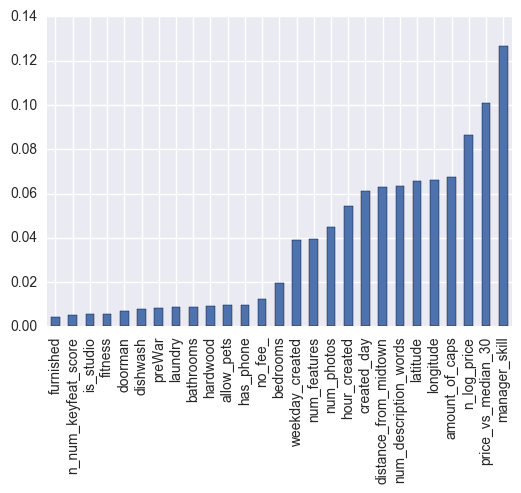

In [22]:
pd.Series(index = feats_used, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

In [ ]:
#compute cross-validation score accuracy across 5 folds
cross_val_scores = cross_val_score(rf,x,y,cv=5)
print "5-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)

In [58]:
#some baseline features according to some good rule of thumbs for gbm params

feats_used = ['bathrooms', 'bedrooms', 'created_day', 'latitude', 'longitude',\
             'n_log_price', 'price_vs_median_30', 'num_photos', 'num_features', 'num_description_words', 'weekday_created',\
             'hour_created', 'is_studio', 'n_num_keyfeat_score','amount_of_caps', 'distance_from_midtown', 'allow_pets',\
              'laundry', 'preWar','furnished','dishwash','hardwood','fitness','doorman','no_fee_', 'has_phone',\
              'dist_to_nearest_tube', 'dist_to_nearest_college']
from sklearn.ensemble import GradientBoostingClassifier
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
gbm0 = GradientBoostingClassifier(n_estimators=1000, max_features=5)
gbm0.fit(x_train,y_train)
y_pred2 = gbm0.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred2)

0.56765504051624116

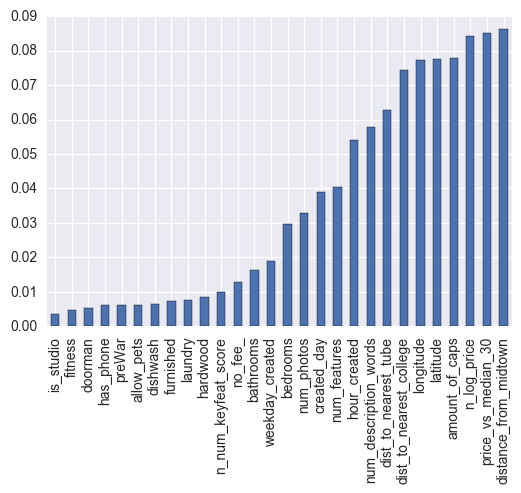

In [59]:
pd.Series(index = feats_used, data = gbm0.feature_importances_).sort_values().plot(kind = 'bar')

In [60]:
#some baseline features according to some good rule of thumbs for gbm params

feats_used = ['bathrooms', 'bedrooms', 'created_day', 'latitude', 'longitude', 'manager_skill', \
             'n_log_price', 'price_vs_median_30', 'num_photos', 'num_features', 'num_description_words', 'weekday_created',\
             'hour_created', 'is_studio', 'n_num_keyfeat_score','amount_of_caps', 'distance_from_midtown', 'allow_pets',\
              'laundry', 'preWar','furnished','dishwash','hardwood','fitness','doorman','no_fee_', 'has_phone',\
              'dist_to_nearest_tube', 'dist_to_nearest_college']
from sklearn.ensemble import GradientBoostingClassifier
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
gbm1 = GradientBoostingClassifier(n_estimators=1000, max_features=5)
gbm1.fit(x_train,y_train)
y_pred2 = gbm1.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred2)

0.54841766752435006

In [ ]:
pd.Series(index = feats_used, data = gbm1.feature_importances_).sort_values().plot(kind = 'bar')

In [35]:
from sklearn.grid_search import GridSearchCV
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8),\
                        param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(drace_df[feats_used],y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=8, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [36]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.61870, std: 0.00500, params: {'n_estimators': 20},
  mean: -0.59234, std: 0.00498, params: {'n_estimators': 30},
  mean: -0.57989, std: 0.00677, params: {'n_estimators': 40},
  mean: -0.57125, std: 0.00543, params: {'n_estimators': 50},
  mean: -0.56716, std: 0.00595, params: {'n_estimators': 60},
  mean: -0.56293, std: 0.00620, params: {'n_estimators': 70},
  mean: -0.56005, std: 0.00605, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 -0.56004877662787267)

In [46]:
#DO NOT RUN THESE PARAM TESTS UNLESS YOU WANT TO VALIDATE FOR YOURSELF.  TAKES VERY LONG!!!
param_test2 = {'max_depth':range(1,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt',subsample=0.8),\
                        param_grid = param_test2, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch2.fit(drace_df[feats_used],y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [47]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.65077, std: 0.00638, params: {'min_samples_split': 200, 'max_depth': 1},
  mean: -0.64940, std: 0.00530, params: {'min_samples_split': 400, 'max_depth': 1},
  mean: -0.64828, std: 0.00533, params: {'min_samples_split': 600, 'max_depth': 1},
  mean: -0.64909, std: 0.00572, params: {'min_samples_split': 800, 'max_depth': 1},
  mean: -0.65034, std: 0.00579, params: {'min_samples_split': 1000, 'max_depth': 1},
  mean: -0.59702, std: 0.00607, params: {'min_samples_split': 200, 'max_depth': 3},
  mean: -0.59712, std: 0.00651, params: {'min_samples_split': 400, 'max_depth': 3},
  mean: -0.59684, std: 0.00528, params: {'min_samples_split': 600, 'max_depth': 3},
  mean: -0.59749, std: 0.00635, params: {'min_samples_split': 800, 'max_depth': 3},
  mean: -0.59727, std: 0.00539, params: {'min_samples_split': 1000, 'max_depth': 3},
  mean: -0.57336, std: 0.00653, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: -0.57397, std: 0.00577, params: {'min_samples_split': 400, 'max_de

In [48]:
param_test3 = {'min_samples_split':range(1,400, 20), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=11,max_features='sqrt',subsample=0.8),\
                        param_grid = param_test3, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch3.fit(drace_df[feats_used],y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=11, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381], 'min_samples_leaf': [30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [49]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.55856, std: 0.00542, params: {'min_samples_split': 1, 'min_samples_leaf': 30},
  mean: -0.55877, std: 0.00547, params: {'min_samples_split': 21, 'min_samples_leaf': 30},
  mean: -0.55858, std: 0.00638, params: {'min_samples_split': 41, 'min_samples_leaf': 30},
  mean: -0.55807, std: 0.00581, params: {'min_samples_split': 61, 'min_samples_leaf': 30},
  mean: -0.55790, std: 0.00539, params: {'min_samples_split': 81, 'min_samples_leaf': 30},
  mean: -0.55653, std: 0.00600, params: {'min_samples_split': 101, 'min_samples_leaf': 30},
  mean: -0.55614, std: 0.00659, params: {'min_samples_split': 121, 'min_samples_leaf': 30},
  mean: -0.55711, std: 0.00505, params: {'min_samples_split': 141, 'min_samples_leaf': 30},
  mean: -0.55585, std: 0.00650, params: {'min_samples_split': 161, 'min_samples_leaf': 30},
  mean: -0.55660, std: 0.00605, params: {'min_samples_split': 181, 'min_samples_leaf': 30},
  mean: -0.55607, std: 0.00598, params: {'min_samples_split': 201, 'min_samples_leaf':

In [51]:
param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,min_samples_leaf=30,max_depth=11,min_samples_split=241, max_features='sqrt'),\
                        param_grid = param_test4, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch4.fit(drace_df[feats_used],y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=11, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=30, min_samples_split=241,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [52]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.55706, std: 0.00563, params: {'subsample': 0.6},
  mean: -0.55737, std: 0.00589, params: {'subsample': 0.7},
  mean: -0.55645, std: 0.00657, params: {'subsample': 0.75},
  mean: -0.55563, std: 0.00556, params: {'subsample': 0.8},
  mean: -0.55538, std: 0.00564, params: {'subsample': 0.85},
  mean: -0.55505, std: 0.00604, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 -0.55505476573394408)

In [56]:
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
gbmtuned = GradientBoostingClassifier(n_estimators=80, max_features='sqrt', subsample=0.9, min_samples_leaf=30, min_samples_split=241, max_depth=11)
gbmtuned.fit(x_train,y_train)
y_pred2 = gbmtuned.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred2)

0.55391695477074154

In [ ]:
#something really wrong here ... I'll have to check when not so tired.

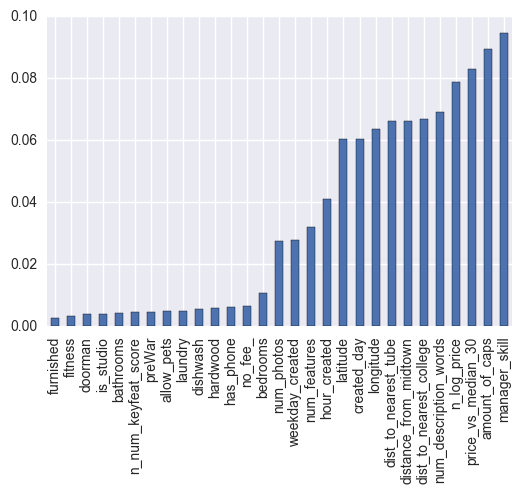

In [54]:
pd.Series(index = feats_used, data = gbmtuned.feature_importances_).sort_values().plot(kind = 'bar')